The goal of this notebook is to quantify the importance of each sig, by noising it at different levels.

Configurables:
    1. model's directory
    2. input data's directory that the model used (might need to recreate data)
    3. function specific--train/val, timestep, perturb amount 


Deliverables
    1. Our all_sigs() function plots each of the sigs that has been noised, comparing it to the original unnoised data
    
Setup
    1. The second cell dictates where the analysis should be done
    2. Run the third cell to store the conf file for the analysis
    3. Run data_loader to store all the data pertaining to the unnoised data
    4. Run the expensive_ops() to store the data pertaining to calculating the global model error for each noised sig

In [40]:
##############
#IMPORTS

import pickle
import numpy as np
import copy 
from sklearn import decomposition
import os
import matplotlib.pyplot as plt
import yaml
from keras import models
from keras import layers
from keras import optimizers
import tensorflow as tf
from helpers import helper_functions

def load_obj(name):
    with open(name+'.pkl', 'rb') as f:
        return pickle.load(f, encoding='latin1')

# Gaussian normalization, return 0 if std is 0
def normalize(obj, mean, std):
    a = obj-mean
    b=std
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

# load conf file, 'config'
def load_config(config_file):
    with open(config_file) as f:
        config = yaml.load(f)
    return config

Quick checks for new models/directories:
If you are using a new model with different delays make sure:
    1. You either overwrite an existing dir or create a new one to store the new data
    2. If you are creating a new dir, make sure to copy over rho standard and final data using the cp source       destination command
    

In [267]:
#modify this accordingly to where the results (model) is saved
results_dir='/global/cscratch1/sd/al34/autoruns/shuffled_delay_100ms_plus/ncomponents_None_lookback_3_prelayers_2_size_10_rnnsize_20_rnndropout_0_recurrentdropout_0_densedropout_0_delay_10_numfinallayers_0'


#modify this accordingly to where the data is stored, or where you want the new data to be stored (train data, shot nums, etc), this is kind of a throwaway dir as you will overwrite this each time you change your 
# results_dir for each conf file, but it should be fine because you will save your new data from data_loader()
data_dir='/global/homes/a/al34/delayed_data_files/'






In [268]:
# define a function to load in the necessary data, first creating the data files with the necessary delay times
def data_loader(results_dir, data_dir):
    
    print("Loading the model/conf file in from: " + results_dir)
    
    ################
    # Load in the conf file
    model_filename='model.h5'




    config=load_config(os.path.join(results_dir,'conf.yaml'))['data']
    config_entire = load_config(os.path.join(results_dir,'conf.yaml'))


    ###############
    #LOAD the model in

    
    # load model, 'loaded_model'
    loaded_model=models.load_model(os.path.join(results_dir,model_filename))

    loaded_model.compile(optimizer=optimizers.RMSprop(lr=.001),
                         metrics=['mae'], loss='mse')
    print("This is what the conf file you gave me looks like: ")
    print(config)


    #############
    # preprocess the data and save it based on the conf file
    helper_functions.preprocess_data(dirname=data_dir, 
                                    sigs_0d=config['sigs_0d'],
                                    sigs_1d=config['sigs_1d'],
                                    sigs_predict=config['sigs_predict'],
                                    n_components=config['n_components'],
                                    avg_window=config['avg_window'],
                                    lookback=config['lookback'],
                                    delay=config['delay'],
                                    train_frac=config['train_frac'],
                                    val_frac=config['val_frac'],
                                    save_data=True, noised_signal = None)    
    

    print("Reading the newly processed data from: " + data_dir)
    
    # load raw data, 'raw_data'
    with open(os.path.join(data_dir,'final_data.pkl'), 'rb') as f: 
            raw_data=pickle.load(f, encoding='latin1')


    # load processed train data, 'train_data'
    with open(os.path.join(data_dir,'train_data.pkl'), 'rb') as f: 
            train_data=pickle.load(f, encoding='latin1')


    # load processed val data, 'val_data'
    with open(os.path.join(data_dir,'val_data.pkl'), 'rb') as f: 
            val_data=pickle.load(f, encoding='latin1')

    # load processed train target, 'train_target'
    with open(os.path.join(data_dir,'train_target.pkl'), 'rb') as f: 
            train_target=pickle.load(f, encoding='latin1')

    # load processed val target, 'val_target'
    with open(os.path.join(data_dir,'val_target.pkl'), 'rb') as f: 
            val_target=pickle.load(f, encoding='latin1')


    # load processed shot indices, a dictionary, 'shot_dict'
    with open(os.path.join(data_dir,'shot_indices.pkl'), 'rb') as f: 
            shot_dict=pickle.load(f, encoding='latin1')





    # load process true train times, 'train_real_times'
    with open(os.path.join(data_dir,'train_time.pkl'), 'rb') as f: 
            train_real_times=pickle.load(f, encoding='latin1')

    # load process true val times, 'val_real_times'
    with open(os.path.join(data_dir,'val_time.pkl'), 'rb') as f: 
            val_real_times=pickle.load(f, encoding='latin1')


    # load standard rho points, 'rho_points'
    with open(os.path.join(data_dir,'rho_standard.pkl'), 'rb') as f: 
            rho_points=pickle.load(f, encoding='latin1')


    # load means and standard deviations of data
    means = helper_functions.load_obj(data_dir+'/means')
    stds = helper_functions.load_obj(data_dir+'/stds')


    #################
    #Data organization

    #list of all the shots in sorted (depending) order based on number, 'train_shot_nums'
    train_shot_nums = shot_dict['train_shot_names']

    #list of all the shots in sorted (depending) order based on number

    val_shot_nums = shot_dict['val_shot_names']

    # list of the indices where each shot begins in the data, 'train_shot_indices'
    train_shot_indices = shot_dict['train_shot_indices']

    # list of the indices where each shot begins in the data, 'val_shot_indices'
    val_shot_indices = shot_dict['val_shot_indices']


    # list of 0D and 1D signals, 'sig_keys_0d' and 'sig_keys_1d'
    sig_keys_0d = config['sigs_0d'] #['curr_target', 'pinj']
    sig_keys_1d = config['sigs_1d'] #['e_temp']

    #print(sig_keys_0d)
    all_sigs = sig_keys_0d+sig_keys_1d




    # delay and lookback values
    delay = config['delay']
    lookback = config['lookback']
    
    output_dict = {
    'raw_data' : raw_data,
    'train_data' : train_data,
    'val_data' : val_data,
    'train_target' : train_target,
    'val_target' : val_target,
    'shot_dict' : shot_dict,
    'loaded_model' : loaded_model,
    'train_real_times' : train_real_times,
    'val_real_times' : val_real_times,
    'rho_points' : rho_points,
    'means' : means,
    'stds' : stds,
    'config' : config,
    'config_entire' : config_entire,
    'train_shot_nums' : train_shot_nums,
    'val_shot_nums' : val_shot_nums,
    'train_shot_indices' : train_shot_indices,
    'val_shot_indices' : val_shot_indices,
    'sig_keys_0d' : sig_keys_0d,
    'sig_keys_1d' : sig_keys_1d,
    'all_sigs' : all_sigs,
    'delay' : delay,
    'lookback' : lookback
    
    }
    
    #sanity check that the data matches the delay:
    print("What the timestep window should be: " + str(delay+lookback+1))
    print("What the timestep window is: " + str(train_data.shape[1]))


    #check how many timesteps there are
    print(train_target.shape[0])
    
    
    return output_dict




In [46]:
# #sanity check that the data matches the delay:
# print(delay+lookback+1)
# print(train_data.shape[1])


# #check how many timesteps there are
# print(train_target.shape[0])

In [269]:
# create a dict for data organization (stores the train data, times, etc) in case multiple models need to be read in

delay_10_dict = data_loader(results_dir, data_dir)
#delay_3_dict = data_loader(results_dir, data_dir)

Loading the model/conf file in from: /global/cscratch1/sd/al34/autoruns/shuffled_delay_100ms_plus/ncomponents_None_lookback_3_prelayers_2_size_10_rnnsize_20_rnndropout_0_recurrentdropout_0_densedropout_0_delay_10_numfinallayers_0
This is what the conf file you gave me looks like: 
{'avg_window': 10, 'delay': 10, 'input_dir_name': '/global/homes/a/al34/data_files/', 'lookback': 3, 'n_components': None, 'name': 'lstm_cnn', 'noised_signal': None, 'preprocess': True, 'sigs_0d': ['curr_target', 'pinj'], 'sigs_1d': ['e_temp'], 'sigs_predict': ['e_temp'], 'train_frac': 0.7, 'val_frac': 0.2}
Removed 15 shots with empty arrays
data is not being noised
Number of timesteps in data:
 122234
data is not being noised
Number of timesteps in data:
 34872
saving data to /global/homes/a/al34/delayed_data_files/...
data saved to /global/homes/a/al34/delayed_data_files/
Reading the newly processed data from: /global/homes/a/al34/delayed_data_files/
What the timestep window should be: 14
What the timestep 

In [230]:

# the goal of this function is to compute the noised vs unnoised global mae, for all the train/val data, which is a very expensive task so better to do it once, than each time


# this entails writing the data with noise and appropriate delay times first, then acessing the MAE as needed.
# this function returns a dictionary containing the following keys:
# unnoised_val_mae, unnoised_avg_val_mae, unnoised_std_val_mae, noised_val_mae, noised_avg_val_mae, noised_std_val_mae, noised_train_data, noised_val_data


def expensive_operations(sigma, perturb_sig, train, raw_data, train_data, val_data, train_target, val_target, shot_dict, loaded_model, train_real_times, val_real_times, 
                         rho_points, means, stds, config, config_entire, train_shot_nums, val_shot_nums, train_shot_indices, val_shot_indices, sig_keys_0d, sig_keys_1d, all_sigs, delay, lookback):
    outgoing_data_dir ='/global/homes/a/al34/noised_data_files/'

    
   
    # save the noised data into a file
    # modify this accordingly to where you want to save the preprocessed data
    # can change the noised_signal too here, depending on what you want
    
    print("Writing the noised data to the following throwaway dir:\n " + outgoing_data_dir)
    print("This is what the conf file looks like: ")
    print(config)

    # make sure to copy the final data to the new dir if you are making one
    helper_functions.preprocess_data(dirname=outgoing_data_dir, 
                                    sigs_0d=config['sigs_0d'],
                                    sigs_1d=config['sigs_1d'],
                                    sigs_predict=config['sigs_predict'],
                                    n_components=config['n_components'],
                                    avg_window=config['avg_window'],
                                    lookback=config['lookback'],
                                    delay=config['delay'],
                                    train_frac=config['train_frac'],
                                    val_frac=config['val_frac'],
                                    save_data=True, noised_signal = perturb_sig, sigma = sigma)
    
    print("Reading the newly processed noised data from:\n" + outgoing_data_dir)
    
    # load processed train data, 'train_data'
    with open(os.path.join(outgoing_data_dir,'train_data.pkl'), 'rb') as f: 
        noised_train_data=pickle.load(f, encoding='latin1')
        
        
    # load processed val data, 'val_data'
    with open(os.path.join(outgoing_data_dir,'val_data.pkl'), 'rb') as f: 
        noised_val_data=pickle.load(f, encoding='latin1')
        
        
    if train:
        shot_indices = train_shot_indices
        data = train_data
        real_times = train_real_times
        shot_nums = train_shot_nums
        target = train_target
        
        noised_data = noised_train_data
        
        
    else:
        shot_indices = val_shot_indices
        data = val_data
        real_times = val_real_times
        shot_nums = val_shot_nums
        target = val_target
        
        noised_data = noised_val_data
    
    print("model predicting for noised and unnoised data globally")
    # compute model MAE on noised, original for global analysis
    unnoised_val_mae = abs(loaded_model.predict(data)-target)
    unnoised_avg_val_mae=np.mean(unnoised_val_mae, axis=0)
    unnoised_std_val_mae=np.std(unnoised_val_mae, axis=0)

    noised_val_mae = abs(loaded_model.predict(noised_data)-target)
    noised_avg_val_mae=np.mean(noised_val_mae, axis=0)
    noised_std_val_mae=np.std(noised_val_mae, axis=0)
    
    
    
    # compute model MSE on noised, original for global analysis
    unnoised_val_mse= np.mean(np.square((loaded_model.predict(data)-target)), axis=0)
    noised_val_mse= np.mean(np.square((loaded_model.predict(noised_data)-target)), axis=0)

    
    output_data_package = {
        "unnoised_val_mae": unnoised_val_mae,
        "unnoised_avg_val_mae": unnoised_avg_val_mae,
        "unnoised_std_val_mae": unnoised_std_val_mae,
        
        "noised_val_mae": noised_val_mae,
        "noised_avg_val_mae": noised_avg_val_mae,
        "noised_std_val_mae": noised_std_val_mae,
        "noised_train_data": noised_train_data,
        "noised_val_data": noised_val_data,
        
        'unnoised_val_mse': unnoised_val_mse,
        'noised_val_mse': noised_val_mse
    }
    print("done")
    
    print("Here is what a sample timeframe looks like to make sure data is being noised")
    


    timestep = 1
    index_of_perturbed = all_sigs.index(perturb_sig)
    print("index of perturbed sig is: " + str(index_of_perturbed))
    if index_of_perturbed < len(sig_keys_0d):
        plt.plot(train_data[timestep:timestep+50, 0, index_of_perturbed], label = "unnoised")
        plt.plot(noised_train_data[timestep:timestep+50, 0, index_of_perturbed], label = "noised")
        plt.title(perturb_sig + " for timestep " + str(timestep) + " to " + str(timestep+50),  fontsize = 15)
        plt.legend(loc = "best")
    else:
        plt.plot(rho_points, train_data[timestep, 0, 2:], label = "unnoised")
        plt.plot(rho_points, noised_train_data[timestep, 0, 2:], label = "noised")
        plt.title(perturb_sig + " for timestep =" + str(timestep), fontsize = 15)
        plt.legend(loc = "best")
        
        

   
    return output_data_package
    
    
    
    
    
    
    
    
        
    




Writing the noised data to the following throwaway dir:
 /global/homes/a/al34/noised_data_files/
This is what the conf file looks like: 
{'avg_window': 10, 'delay': 3, 'input_dir_name': '/global/homes/a/al34/data_files/', 'lookback': 3, 'n_components': None, 'name': 'lstm_cnn', 'noised_signal': None, 'preprocess': True, 'sigs_0d': ['curr_target', 'pinj'], 'sigs_1d': ['e_temp'], 'sigs_predict': ['e_temp'], 'train_frac': 0.7, 'val_frac': 0.2}
Removed 15 shots with empty arrays
noising data for e_temp with 0.51
Number of timesteps in data:
 126635
noising data for e_temp with 0.51
Number of timesteps in data:
 36118
saving data to /global/homes/a/al34/noised_data_files/...
data saved to /global/homes/a/al34/noised_data_files/
Reading the newly processed noised data from:
/global/homes/a/al34/noised_data_files/
model predicting for noised and unnoised data globally
done
Here is what a sample timeframe looks like to make sure data is being noised
index of perturbed sig is: 2


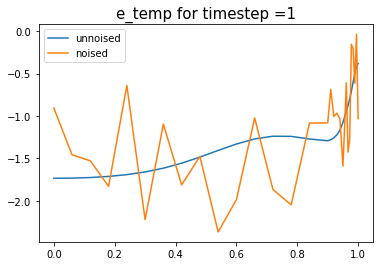

In [232]:
# make sure the sig name is exact here, as we need it directly for preprocessing
# sigs_0d': ['curr_target', 'pinj'], 'sigs_1d': ['e_temp']
#perturb_sig = "e_temp"
train = False
sigma = 0.51
data_dict = delay_3_dict

#delay_10_expensive_dict_etemp = expensive_operations(sigma, "e_temp", train, **delay_10_dict)

#delay_10_expensive_dict_curr = expensive_operations(sigma, "curr_target", train, **delay_10_dict)
# delay_10_expensive_dict_pinj = expensive_operations(sigma, "pinj", train, **delay_10_dict)

#delay_3_expensive_dict_pinj = expensive_operations(sigma, "pinj", train, **data_dict)
#delay_3_expensive_dict_curr = expensive_operations(sigma, "curr_target", train, **data_dict)
delay_3_expensive_dict_etemp = expensive_operations(sigma, "e_temp", train, **data_dict)

In [246]:
# this function takes in the dictionary containing all the data, as well as the dictionary from the expensive ops function, and then plots some global and local indicators
def signal_importance(perturb_sig, timestep, train, 
        raw_data, train_data, val_data, train_target, val_target, shot_dict, loaded_model, train_real_times, val_real_times, rho_points, means, stds, config, config_entire,
         train_shot_nums, val_shot_nums, train_shot_indices, val_shot_indices, 
         sig_keys_0d, sig_keys_1d, all_sigs, delay, lookback, unnoised_val_mae, unnoised_avg_val_mae, unnoised_std_val_mae, 
         noised_val_mae, noised_avg_val_mae, noised_std_val_mae, noised_train_data, noised_val_data, noised_val_mse, unnoised_val_mse):
    
    
    titlesize = 15
    
    if train:
        shot_indices = train_shot_indices
        data = train_data
        real_times = train_real_times
        shot_nums = train_shot_nums
        target = train_target
        
        noised_data = noised_train_data
        
        
    else:
        shot_indices = val_shot_indices
        data = val_data
        real_times = val_real_times
        shot_nums = val_shot_nums
        target = val_target
        
        noised_data = noised_val_data
        
    
    
    
    # shot index of timestep 
    shot_index = np.searchsorted(shot_indices, timestep, side='right')-1
    # range of times for that timestep's shot
    timestep_range = list(range(shot_indices[shot_index], shot_indices[shot_index+1]))
    fig = plt.figure(figsize = (20,25))
    
    
    #==================================================================================================
    #PLOTTING CONTEXT ON LEFT PANE
    
    # plot entire shot history for each 0D sig, with a vertical line symbolizing location 
    # of timestep of interest
    for i in range(len(sig_keys_0d)):
        plot_position = '{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*i+1) 
        tmp_fig = fig.add_subplot(plot_position)
        # get the sig data from the processed data, (which has been shortened by smoothing/lookback)
        sig_data = np.ndarray.flatten(data[timestep_range, lookback, i])
        #joe's version below
        #sig_data=np.array(data)[timestep_range,-delay-1,i].T
        
        
        time_data = real_times[timestep_range]
        
        tmp_fig.plot(time_data, sig_data)
        tmp_fig.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)
        tmp_fig.axvline(real_times[timestep],color='r')
        tmp_fig.axvline(real_times[timestep+delay],color='b')
        
        
    # plot entire shot history for each 1D sig (averaged rho's for each timestep), with a vertical line symbolizing location 
    # of timestep of interest    
    for i in range(len(sig_keys_1d)):
        plot_position = '{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*(len(sig_keys_0d)+i)+1) 
        tmp_fig = fig.add_subplot(plot_position)
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        sig_data = (data[timestep_range, lookback,len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in])
        # average the rho-values across each timestep
        sig_data = (np.mean(sig_data, axis = 1))
        
        
        #noised_sig_data = (noised_data[timestep_range, lookback,len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in])
        # average the rho-values across each timestep
        #noised_sig_data = (np.mean(noised_sig_data, axis = 1))
        
        
        time_data = real_times[timestep_range]
        tmp_fig.plot(time_data, sig_data)
        #tmp_fig.plot(time_data, noised_sig_data)

        tmp_fig.axvline(real_times[timestep],color='r')
        tmp_fig.axvline(real_times[timestep+delay],color='b')
        tmp_fig.set_ylabel(sig_keys_1d[i] + "(averaged across rho-points)", fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)
    
    
    
    ##################################################################################
    # local perturb work, plotted on top right
    # noise the signal a by a lot
    
    input_data=np.array(data)[timestep:timestep+1]
    predicted_profile = np.ndarray.flatten(loaded_model.predict(input_data))   
    
    
    
    
    # add noised and predict
    noised_input_data=np.array(noised_data)[timestep:timestep+1]
    noised_predicted_profile = np.ndarray.flatten(loaded_model.predict(noised_input_data))  
    
    
    true_profile = target[timestep]
    
    
    

    

    # begin plotting
    plot_position = 322
    tmp_fig = fig.add_subplot(plot_position)
    # plot predicted
    tmp_fig.plot(rho_points, predicted_profile, label = "no noise, model predicted change", color = 'r')
    
   
    tmp_fig.plot(rho_points, noised_predicted_profile, label = "noised {}, model predicted change".format(perturb_sig), color = 'green')


  
    
    # add baseline and true target
    # plot true
    tmp_fig.plot(rho_points, true_profile, label = "True Profile", color = 'blue')
    # plot baseline (no change)
    tmp_fig.axhline(0,label='Baseline', color='cyan')
    tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)
    tmp_fig.set_ylabel("change in standardized e_temp values (in std)", fontsize=titlesize)
    


    tmp_fig.legend(loc = "best", fontsize=10)
    
    
    
    ##################################################################################
    # global perturb work, plotted on bottom right
    # noise the signal a by a lot
    
    
    #compute baseline MAE
    baseline_mae=abs(target)
    avg_baseline_mae=np.mean(baseline_mae, axis=0)
    std_baseline_mae=np.std(baseline_mae, axis=0)
    
    
    #compute the snapshot error
    predicted_error = abs(true_profile - predicted_profile)
    baseline_error = abs(true_profile)
    noised_error = abs(true_profile - noised_predicted_profile)
    
    
    #begin the plotting
    plot_position = 324
    tmp_fig = fig.add_subplot(plot_position)
    tmp_fig.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline MAE', linewidth=3)
    tmp_fig.plot(rho_points, unnoised_avg_val_mae, color = 'red', linestyle = '--', label = "Average unnoised MAE", linewidth = 3)
    tmp_fig.plot(rho_points, noised_avg_val_mae, color = 'green', linestyle = '--', label = "Average noised MAE", linewidth = 3)
    
    
#     tmp_fig.plot(rho_points, predicted_error, color='red', label='unnoised predicted error for one example', linewidth=7)
#     tmp_fig.plot(rho_points, noised_error, color='green', label='noised predicted error for one example', linewidth=7)

    
    tmp_fig.legend(loc="best", fontsize = 12)
    tmp_fig.set_title("Noising {}, Global MAE over all Shots with Delay = {}ms".format(perturb_sig, delay*20), fontsize = titlesize*1.5)
    tmp_fig.set_ylabel("MAE", fontsize=titlesize)
    tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)

  
        
    #########################################################################################    
    # plot mse
    
    #compute baseline MSE
    baseline_mse=np.square(target)
    avg_baseline_mse=np.mean(baseline_mse, axis=0)
    
    plot_position = 326
    tmp_fig = fig.add_subplot(plot_position)
    tmp_fig.plot(rho_points, noised_val_mse, color = 'green', label = "average noised mse", linestyle = '--')
    tmp_fig.plot(rho_points, unnoised_val_mse, color = 'red', label = "average unnoised mse", linestyle = '--')
    tmp_fig.plot(rho_points, avg_baseline_mse, color = 'blue', label = "average baseline mse", linestyle = '--')
       
    tmp_fig.legend(loc="best", fontsize = 12)
    tmp_fig.set_title("Noising {}, Global MSE over all Shots with Delay = {}ms".format(perturb_sig, delay*20), fontsize = titlesize*1.5)
    tmp_fig.set_ylabel("MAE", fontsize=titlesize)
    tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)
    tmp_fig.set_ylim(0,0.2)

    #########################################################################################
    # print title out 
    if train:
        data_type = "Train"
    else:
        data_type = "Val"
    fig.suptitle('Shot {} (timestep {}) of val data, Perturbing {} with {} ms delay'.format(shot_nums[shot_index],timestep, perturb_sig, delay*20), fontsize = 30)
       
    




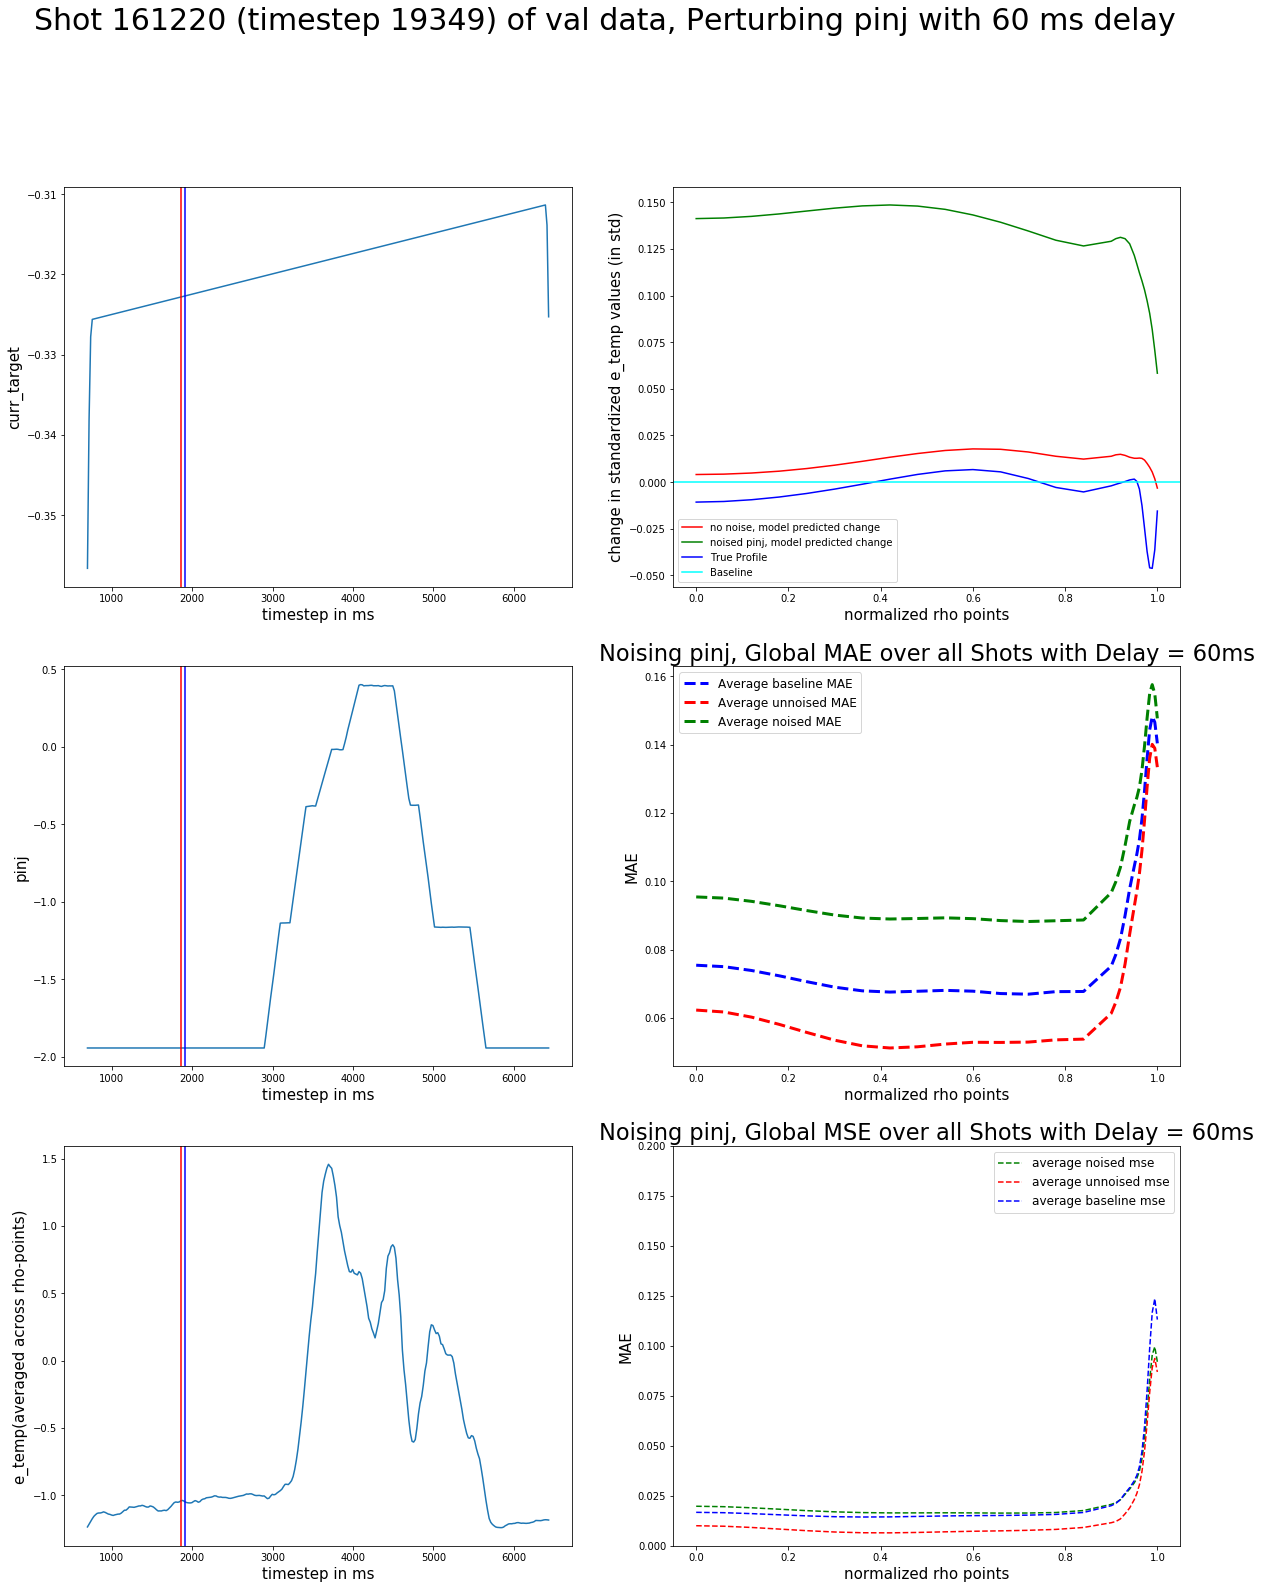

In [248]:

#plot the results of noising the input sig, change the dict for different sigs

#name of perturb sig here is not particularly important for the code to run
perturb_sig = "pinj"
timestep = np.random.choice(range(delay_3_dict['val_shot_indices'][-1]))
timestep = 19349

train = False
signal_importance(perturb_sig, timestep, train, **delay_3_expensive_dict_pinj, **delay_3_dict)

In [244]:
# # sanity check to make sure the pinj is noised properly
# noised_train = delay_10_expensive_dict['noised_train_data']
# regular_train = delay_10_dict['train_data']

# timestep = 1
# index_of_perturbed = 1

# plt.plot(regular_train[timestep, :, index_of_perturbed])
# plt.plot(noised_train[timestep, :, index_of_perturbed])
# plt.ylabel("pinj")

In [243]:
# #sanity check to make sure etemp was nosied properly
# noised_train = delay_10_expensive_dict_etemp['noised_train_data']
# regular_train = delay_10_dict['train_data']

# timestep = 1
# index_of_perturbed = 1

# plt.plot(delay_10_dict['rho_points'], regular_train[timestep, 0, 2:])
# plt.plot(delay_10_dict['rho_points'], noised_train[timestep, 0, 2:])
# plt.ylabel("etemp")


In [238]:
# this function takes in the dictionary containing all the data, as well as the dictionary from the expensive ops function, and then plots some global and local indicators
def all_sigs(timestep, train, 
        raw_data, train_data, val_data, train_target, val_target, shot_dict, loaded_model, train_real_times, val_real_times, rho_points, means, stds, config, config_entire,
         train_shot_nums, val_shot_nums, train_shot_indices, val_shot_indices, 
         sig_keys_0d, sig_keys_1d, all_sigs, delay, lookback, curr_dict, pinj_dict, etemp_dict):
    
    
    titlesize = 15
    if train:
        shot_indices = train_shot_indices
        data = train_data
        real_times = train_real_times
        shot_nums = train_shot_nums
        target = train_target
        
        #noised_data = noised_train_data
        
        
    else:
        shot_indices = val_shot_indices
        data = val_data
        real_times = val_real_times
        shot_nums = val_shot_nums
        target = val_target
        
        #noised_data = noised_val_data
        
    
  
    # shot index of timestep 
    shot_index = np.searchsorted(shot_indices, timestep, side='right')-1
    # range of times for that timestep's shot
    timestep_range = list(range(shot_indices[shot_index], shot_indices[shot_index+1]))
    fig = plt.figure(figsize = (30,25))
    
    
    #==================================================================================================
    #PLOTTING CONTEXT ON LEFT PANE
    
    # plot entire shot history for each 0D sig, with a vertical line symbolizing location 
    # of timestep of interest
    for i in range(len(sig_keys_0d)):
        plot_position = '{}3{}'.format(len(sig_keys_0d)+len(sig_keys_1d),3*i+1) 
        tmp_fig = fig.add_subplot(plot_position)
        # get the sig data from the processed data, (which has been shortened by smoothing/lookback)
        sig_data = np.ndarray.flatten(data[timestep_range, lookback, i])
        #joe's version below
        #sig_data=np.array(data)[timestep_range,-delay-1,i].T
        
        
        time_data = real_times[timestep_range]
        
        tmp_fig.plot(time_data, sig_data)
        tmp_fig.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)
        tmp_fig.axvline(real_times[timestep],color='r')
        tmp_fig.axvline(real_times[timestep+delay],color='b')
        
        
    # plot entire shot history for each 1D sig (averaged rho's for each timestep), with a vertical line symbolizing location 
    # of timestep of interest    
    for i in range(len(sig_keys_1d)):
        plot_position = '{}3{}'.format(len(sig_keys_0d)+len(sig_keys_1d),3*(len(sig_keys_0d)+i)+1) 
        tmp_fig = fig.add_subplot(plot_position)
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        sig_data = (data[timestep_range, lookback,len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in])
        # average the rho-values across each timestep
        sig_data = (np.mean(sig_data, axis = 1))
        
        
        #noised_sig_data = (noised_data[timestep_range, lookback,len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in])
        # average the rho-values across each timestep
        #noised_sig_data = (np.mean(noised_sig_data, axis = 1))
        
        
        time_data = real_times[timestep_range]
        tmp_fig.plot(time_data, sig_data)
        #tmp_fig.plot(time_data, noised_sig_data)

        tmp_fig.axvline(real_times[timestep],color='r')
        tmp_fig.axvline(real_times[timestep+delay],color='b')
        tmp_fig.set_ylabel(sig_keys_1d[i] + "(averaged across rho-points)", fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)
    
    
    
    ##################################################################################
    # LOCAL perturb work, plotted on middle column
    # noise the signal a by a lot
    
    input_data=np.array(data)[timestep:timestep+1]
    predicted_profile = np.ndarray.flatten(loaded_model.predict(input_data))   
    
    true_profile = target[timestep]
    
    
    # add noised and predict
    
    
    # PREDICT CURR/PINJ/ETEMP
    #noised curr
    noised_input_data_curr=np.array(curr_dict['noised_val_data'])[timestep:timestep+1]
    noised_predicted_profile_curr = np.ndarray.flatten(loaded_model.predict(noised_input_data_curr))  
    
    
    #noised pinj
    noised_input_data_pinj=np.array(pinj_dict['noised_val_data'])[timestep:timestep+1]
    noised_predicted_profile_pinj = np.ndarray.flatten(loaded_model.predict(noised_input_data_pinj))  
    
    
    #noised etemp
    noised_input_data_etemp=np.array(etemp_dict['noised_val_data'])[timestep:timestep+1]
    noised_predicted_profile_etemp = np.ndarray.flatten(loaded_model.predict(noised_input_data_etemp))  
    
    
    
    
    
    
    #####################
    

    

    # begin plotting curr
    plot_position = 332
    tmp_fig = fig.add_subplot(plot_position)
    # plot predicted
    tmp_fig.plot(rho_points, predicted_profile, label = "no noise, model predicted change", color = 'r')
    
   
    tmp_fig.plot(rho_points, noised_predicted_profile_curr, label = "noised curr, model predicted change", color = 'green', linewidth = 5)


  
    
    # add baseline and true target
    # plot true
    tmp_fig.plot(rho_points, true_profile, label = "True Profile", color = 'blue')
    # plot baseline (no change)
    tmp_fig.axhline(0,label='Baseline', color='cyan')
    tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)
    tmp_fig.set_ylabel("change in standardized e_temp values (in std)", fontsize=titlesize)
    


    tmp_fig.legend(loc = "best", fontsize=10)
    
    tmp_fig.set_title("CURR")
    
    
    #################
    
     # begin plotting pinj
    plot_position = 335
    tmp_fig = fig.add_subplot(plot_position)
    # plot predicted
    tmp_fig.plot(rho_points, predicted_profile, label = "no noise, model predicted change", color = 'r')
    
   
    tmp_fig.plot(rho_points, noised_predicted_profile_pinj, label = "noised PINJ, model predicted change", color = 'green', linewidth = 5)


  
    
    # add baseline and true target
    # plot true
    tmp_fig.plot(rho_points, true_profile, label = "True Profile", color = 'blue')
    # plot baseline (no change)
    tmp_fig.axhline(0,label='Baseline', color='cyan')
    tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)
    tmp_fig.set_ylabel("change in standardized e_temp values (in std)", fontsize=titlesize)
    


    tmp_fig.legend(loc = "best", fontsize=10)
    tmp_fig.set_title("PINJ")
    
    
    ##################
    
    
     # begin plotting etemp
    plot_position = 338
    tmp_fig = fig.add_subplot(plot_position)
    # plot predicted
    tmp_fig.plot(rho_points, predicted_profile, label = "no noise, model predicted change", color = 'r')
    
   
    tmp_fig.plot(rho_points, noised_predicted_profile_etemp, label = "noised ETEMP, model predicted change", color = 'green', linewidth = 5)


  
    
    # add baseline and true target
    # plot true
    tmp_fig.plot(rho_points, true_profile, label = "True Profile", color = 'blue')
    # plot baseline (no change)
    tmp_fig.axhline(0,label='Baseline', color='cyan')
    tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)
    tmp_fig.set_ylabel("change in standardized e_temp values (in std)", fontsize=titlesize)
    


    tmp_fig.legend(loc = "best", fontsize=10)
    tmp_fig.set_title("ETEMP")
    
    ##################################################################################
    # GLOBAL perturb work, plotted on bottom right
    # noise the signal a by a lot
    
    
    #compute baseline MAE
    baseline_mae=abs(target)
    avg_baseline_mae=np.mean(baseline_mae, axis=0)
    std_baseline_mae=np.std(baseline_mae, axis=0)
    
    
#     #compute the snapshot error
#     predicted_error = abs(true_profile - predicted_profile)
#     baseline_error = abs(true_profile)
#     noised_error = abs(true_profile - noised_predicted_profile)
    
    
    #begin the plotting, curr
    plot_position = 333
    tmp_fig = fig.add_subplot(plot_position)
    tmp_fig.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline MAE', linewidth=3)
    tmp_fig.plot(rho_points, curr_dict['unnoised_avg_val_mae'], color = 'red', linestyle = '--', label = "Average unnoised MAE", linewidth = 3)
    tmp_fig.plot(rho_points, curr_dict['noised_avg_val_mae'], color = 'green', linestyle = '--', label = "Average noised MAE", linewidth = 3)
    
    
    tmp_fig.legend(loc="best", fontsize = 12)
    tmp_fig.set_title("CURR, Global MAE over all Shots with Delay = {}ms".format(delay*20), fontsize = titlesize*1.5)
    tmp_fig.set_ylabel("MAE", fontsize=titlesize)
    tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)

    ########################
     #begin the plotting, pinj
    plot_position = 336
    tmp_fig = fig.add_subplot(plot_position)
    tmp_fig.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline MAE', linewidth=3)
    tmp_fig.plot(rho_points, pinj_dict['unnoised_avg_val_mae'], color = 'red', linestyle = '--', label = "Average unnoised MAE", linewidth = 3)
    tmp_fig.plot(rho_points, pinj_dict['noised_avg_val_mae'], color = 'green', linestyle = '--', label = "Average noised MAE", linewidth = 3)
    
    
    tmp_fig.legend(loc="best", fontsize = 12)
    tmp_fig.set_title("PINJ, Global MAE over all Shots with Delay = {}ms".format(delay*20), fontsize = titlesize*1.5)
    tmp_fig.set_ylabel("MAE", fontsize=titlesize)
    tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)

    
    ########################
     #begin the plotting, etemp
    plot_position = 339
    tmp_fig = fig.add_subplot(plot_position)
    tmp_fig.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline MAE', linewidth=3)
    tmp_fig.plot(rho_points, etemp_dict['unnoised_avg_val_mae'], color = 'red', linestyle = '--', label = "Average unnoised MAE", linewidth = 3)
    tmp_fig.plot(rho_points, etemp_dict['noised_avg_val_mae'], color = 'green', linestyle = '--', label = "Average noised MAE", linewidth = 3)
    
    
    tmp_fig.legend(loc="best", fontsize = 12)
    tmp_fig.set_title("ETEMP, Global MAE over all Shots with Delay = {}ms".format(delay*20), fontsize = titlesize*1.5)
    tmp_fig.set_ylabel("MAE", fontsize=titlesize)
    tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)

    
#     tmp_fig.plot(rho_points, predicted_error, color='red', label='unnoised predicted error for one example', linewidth=7)
#     tmp_fig.plot(rho_points, noised_error, color='green', label='noised predicted error for one example', linewidth=7)

    
    
  
        
#     #########################################################################################    
#     # plot mse
    
#     #compute baseline MSE
#     baseline_mse=np.square(target)
#     avg_baseline_mse=np.mean(baseline_mse, axis=0)
    
#     plot_position = 326
#     tmp_fig = fig.add_subplot(plot_position)
#     tmp_fig.plot(rho_points, noised_val_mse, color = 'green', label = "average noised mse", linestyle = '--')
#     tmp_fig.plot(rho_points, unnoised_val_mse, color = 'red', label = "average unnoised mse", linestyle = '--')
#     tmp_fig.plot(rho_points, avg_baseline_mse, color = 'blue', label = "average baseline mse", linestyle = '--')
       
#     tmp_fig.legend(loc="best", fontsize = 12)
#     tmp_fig.set_title("Noising {}, Global MSE over all Shots with Delay = {}ms".format(perturb_sig, delay*20), fontsize = titlesize*1.5)
#     tmp_fig.set_ylabel("MAE", fontsize=titlesize)
#     tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)
#     tmp_fig.set_ylim(0,0.2)

    #########################################################################################
    # print title out 
    if train:
        data_type = "Train"
    else:
        data_type = "Val"
    fig.suptitle('Shot {} (timestep {}) of val data, with {} ms delay'.format(shot_nums[shot_index],timestep, delay*20), fontsize = 30)
       
    




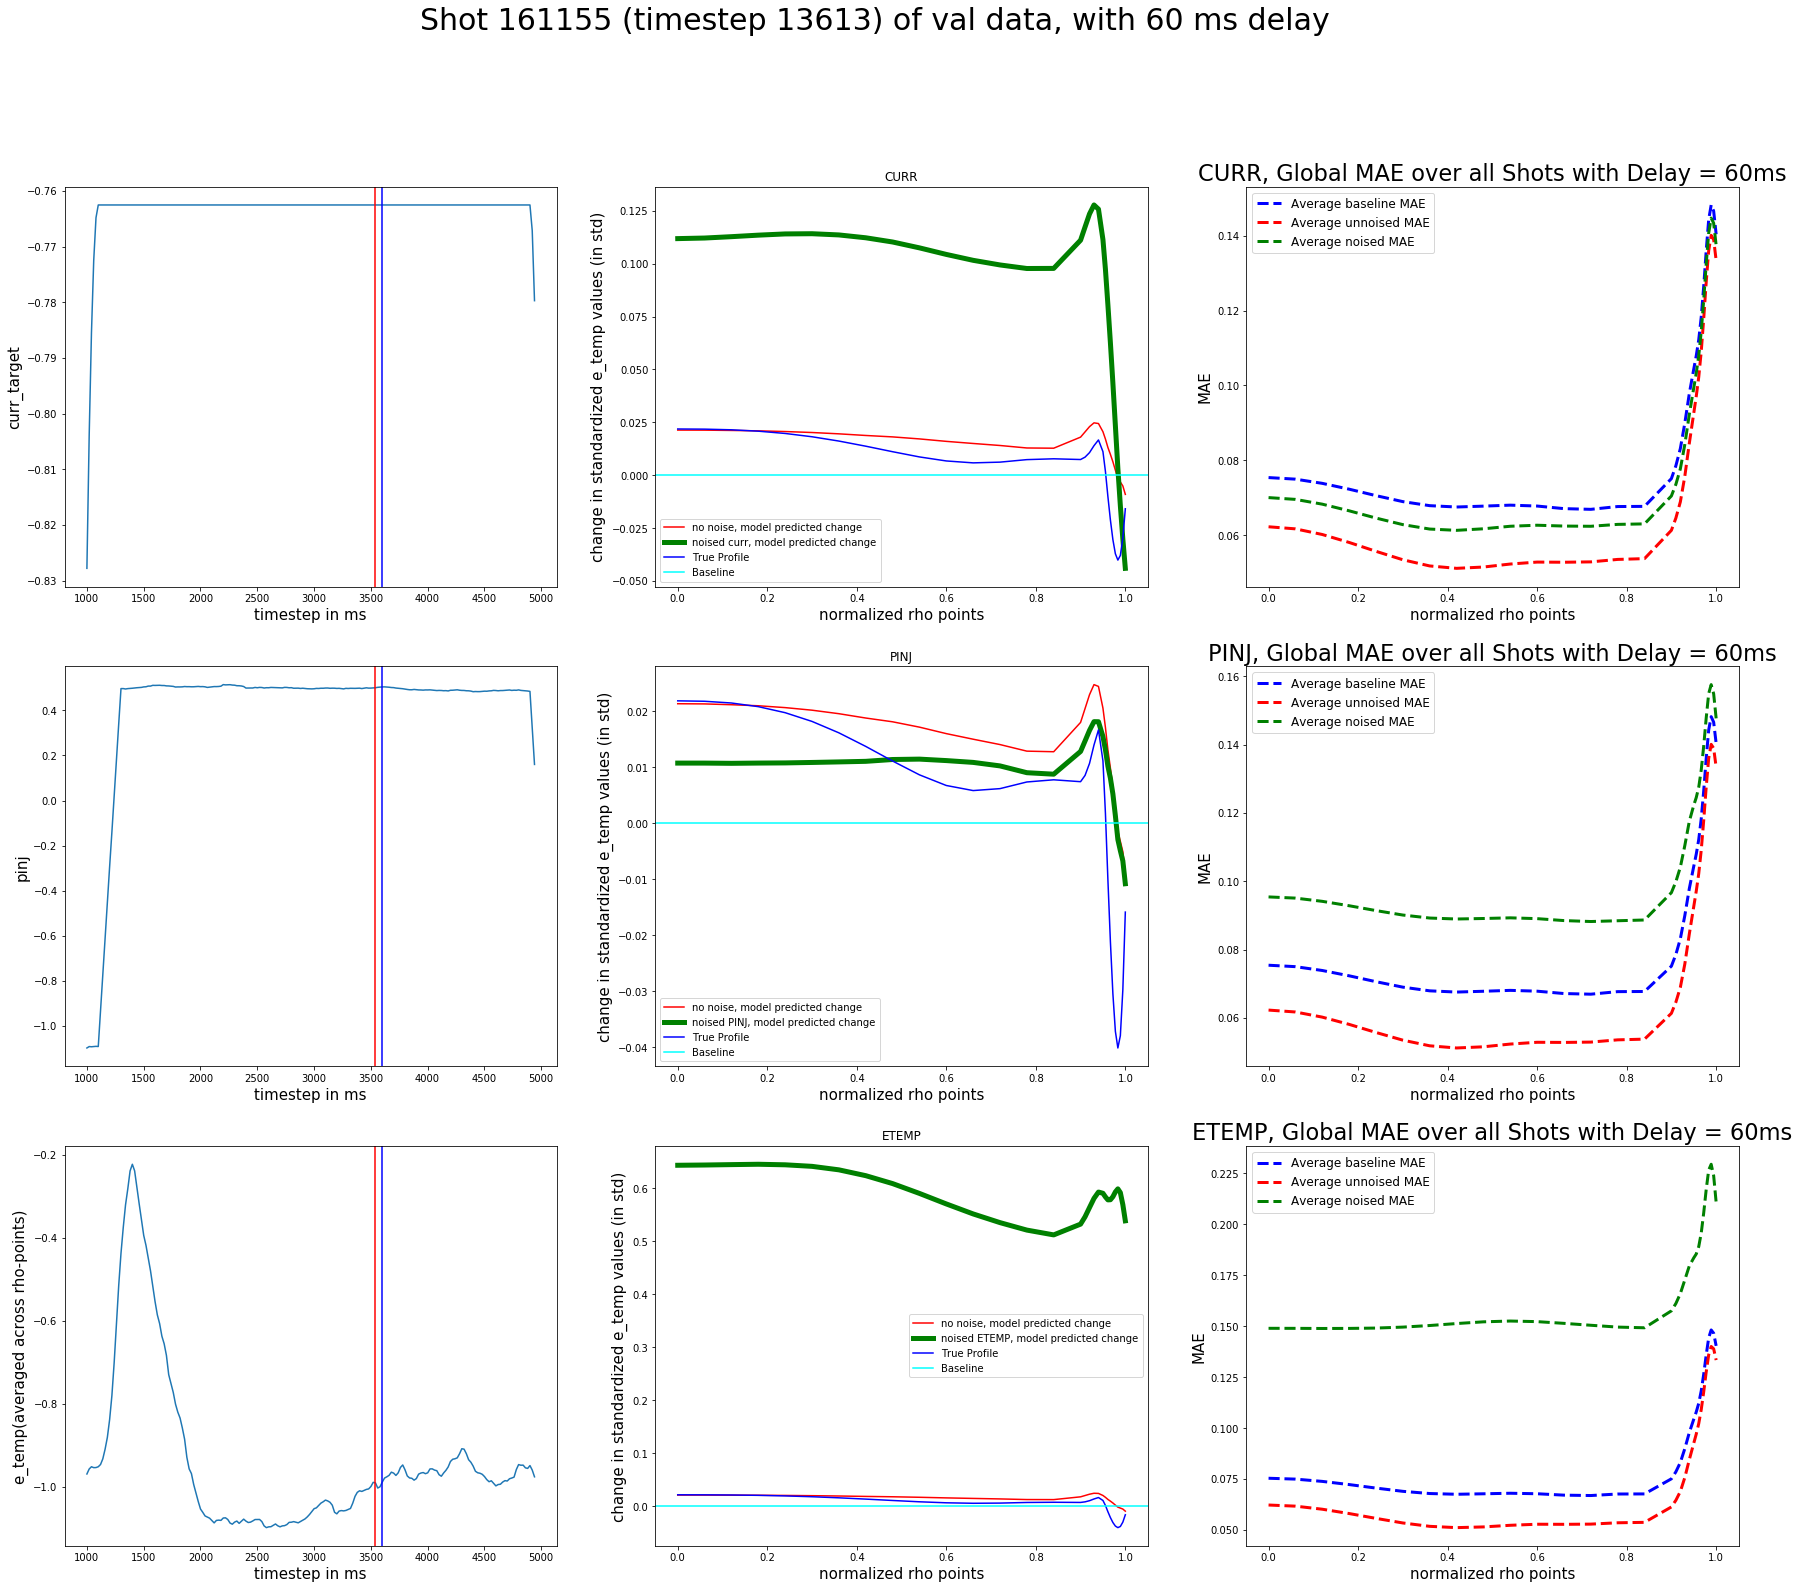

In [303]:

timestep = np.random.choice(range(delay_3_dict['val_shot_indices'][-1]))

#timestep = 3
curr_dict = delay_3_expensive_dict_curr
pinj_dict = delay_3_expensive_dict_pinj
etemp_dict = delay_3_expensive_dict_etemp
data_dict = delay_3_dict


# timestep = np.random.choice(range(delay_10_dict['val_shot_indices'][-1]))


# curr_dict = delay_10_expensive_dict_curr
# pinj_dict = delay_10_expensive_dict_pinj
# etemp_dict = delay_10_expensive_dict_etemp
# data_dict = delay_10_dict




train = False
all_sigs(timestep, train, **data_dict, curr_dict = curr_dict, pinj_dict= pinj_dict, etemp_dict = etemp_dict)

In [146]:
delay_10_expensive_dict_pinj['noised_avg_val_mae']

array([ 0.21974665,  0.21886667,  0.21657594,  0.21342506,  0.21002258,
        0.20713171,  0.20540415,  0.20485017,  0.20500887,  0.20490821,
        0.20401297,  0.20250885,  0.20205795,  0.20350702,  0.20502954,
        0.22098066,  0.22738925,  0.2354579 ,  0.24735931,  0.2599117 ,
        0.2670221 ,  0.27065444,  0.27695495,  0.28826339,  0.30482047,
        0.32449066,  0.34231633,  0.35157272,  0.34912572,  0.33560044])

In [201]:
config


{'avg_window': 10,
 'delay': 3,
 'input_dir_name': '/global/homes/a/al34/data_files/',
 'lookback': 3,
 'n_components': None,
 'name': 'lstm_cnn',
 'noised_signal': None,
 'preprocess': True,
 'sigs_0d': ['curr_target', 'pinj'],
 'sigs_1d': ['e_temp'],
 'sigs_predict': ['e_temp'],
 'train_frac': 0.7,
 'val_frac': 0.2}

In [203]:
delay_10_expensive_dict_curr['unnoised_avg_val_mae']

array([ 0.18378299,  0.18273887,  0.17996476,  0.17608349,  0.17173281,
        0.16775903,  0.16529095,  0.16462302,  0.16513781,  0.16570529,
        0.16542971,  0.16437212,  0.16429884,  0.16564655,  0.16637158,
        0.18064585,  0.18724381,  0.19572761,  0.2090491 ,  0.22486955,
        0.23757593,  0.24445026,  0.25354591,  0.26705055,  0.28554213,
        0.3071403 ,  0.32626862,  0.33534038,  0.33187917,  0.31763792])

In [204]:
delay_10_expensive_dict_etemp['unnoised_avg_val_mae']

array([ 0.18378299,  0.18273887,  0.17996476,  0.17608349,  0.17173281,
        0.16775903,  0.16529095,  0.16462302,  0.16513781,  0.16570529,
        0.16542971,  0.16437212,  0.16429884,  0.16564655,  0.16637158,
        0.18064585,  0.18724381,  0.19572761,  0.2090491 ,  0.22486955,
        0.23757593,  0.24445026,  0.25354591,  0.26705055,  0.28554213,
        0.3071403 ,  0.32626862,  0.33534038,  0.33187917,  0.31763792])

In [220]:
test = ['a', 'b', 'c']
test.index('a')

0

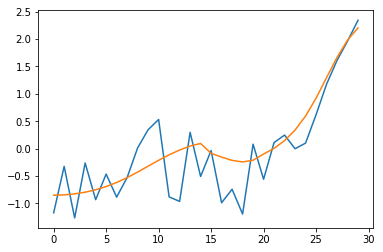

In [264]:
plt.plot(np.ndarray.flatten((np.array(delay_10_expensive_dict_etemp['noised_val_data'])[timestep:timestep+1, 0, 2:])))
plt.plot(np.ndarray.flatten((np.array(delay_10_dict['val_data'])[timestep:timestep+1, 0, 2:])))


In [299]:
delay_10_dict['val_data'][0]

array([[-0.06612856, -1.94337711, -1.90174426, -1.9017039 , -1.90090102,
        -1.897541  , -1.88906737, -1.87231199, -1.84390789, -1.80119532,
        -1.74350601, -1.67428577, -1.60033045, -1.53102694, -1.47492472,
        -1.43659909, -1.4196232 , -1.40954253, -1.39755334, -1.37793844,
        -1.35081498, -1.30956207, -1.24401368, -1.20347751, -1.1683707 ,
        -1.14533011, -1.13078102, -1.11458566, -1.0784815 , -1.01062782,
        -0.91429076, -0.80532529],
       [-0.01734369, -1.94337711, -1.87550552, -1.87552394, -1.8749137 ,
        -1.87192709, -1.86408108, -1.84830385, -1.82133776, -1.78062312,
        -1.72554706, -1.65951862, -1.58917633, -1.52359966, -1.47085482,
        -1.43483115, -1.41828694, -1.40578113, -1.39295611, -1.37233193,
        -1.3440232 , -1.30159055, -1.23563158, -1.19575709, -1.16237909,
        -1.14263086, -1.13341281, -1.1249171 , -1.09850574, -1.04090687,
        -0.95361741, -0.85107958],
       [ 0.02431952, -1.94337711, -1.8372981 , -1.8376

In [300]:
delay_3_dict['val_data'][0]

array([[-0.06612856, -1.94337711, -1.90174426, -1.9017039 , -1.90090102,
        -1.897541  , -1.88906737, -1.87231199, -1.84390789, -1.80119532,
        -1.74350601, -1.67428577, -1.60033045, -1.53102694, -1.47492472,
        -1.43659909, -1.4196232 , -1.40954253, -1.39755334, -1.37793844,
        -1.35081498, -1.30956207, -1.24401368, -1.20347751, -1.1683707 ,
        -1.14533011, -1.13078102, -1.11458566, -1.0784815 , -1.01062782,
        -0.91429076, -0.80532529],
       [-0.01734369, -1.94337711, -1.87550552, -1.87552394, -1.8749137 ,
        -1.87192709, -1.86408108, -1.84830385, -1.82133776, -1.78062312,
        -1.72554706, -1.65951862, -1.58917633, -1.52359966, -1.47085482,
        -1.43483115, -1.41828694, -1.40578113, -1.39295611, -1.37233193,
        -1.3440232 , -1.30159055, -1.23563158, -1.19575709, -1.16237909,
        -1.14263086, -1.13341281, -1.1249171 , -1.09850574, -1.04090687,
        -0.95361741, -0.85107958],
       [ 0.02431952, -1.94337711, -1.8372981 , -1.8376

In [283]:
delay_3_dict['train_target'][0:9]

array([[  2.26688396e-01,   2.25150333e-01,   2.20697134e-01,
          2.13296647e-01,   2.02656128e-01,   1.88336913e-01,
          1.69914449e-01,   1.47220798e-01,   1.20656096e-01,
          9.15231602e-02,   6.21675926e-02,   3.60760531e-02,
          1.77619812e-02,   1.18624591e-02,   2.01753098e-02,
          4.05140197e-02,   4.57062046e-02,   5.22077843e-02,
          6.12558767e-02,   7.49715812e-02,   9.66484333e-02,
          1.14780077e-01,   1.40509113e-01,   1.78345718e-01,
          2.33611397e-01,   3.11743569e-01,   4.15243937e-01,
          5.35448352e-01,   6.51686219e-01,   7.37833500e-01],
       [  2.45670224e-01,   2.43765962e-01,   2.38247522e-01,
          2.29087389e-01,   2.15957711e-01,   1.98371886e-01,
          1.75881261e-01,   1.48369032e-01,   1.16424298e-01,
          8.17376938e-02,   4.72958664e-02,   1.75315325e-02,
         -1.77755192e-03,  -4.67729032e-03,   1.09053158e-02,
          4.00994234e-02,   4.65759923e-02,   5.42880728e-02,
       